In [1]:
# tests/test_sedov_amr.py

import os

#using GPU, comment out if on CPU
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '3'
import jax 
jax.config.update('jax_disable_jit', False)
jax.config.update('jax_debug_nans', True)

import sys
import jax
import jax.numpy as jnp
import numpy as np

import diffhydro as dh
from diffhydro.prob_gen.initial_conditions import sedov_2d
from diffhydro.utils.diagnostics import isotropy_score


/home/ben.horowitz/dh_v1/diffhydro/fluxes.py:135: SyntaxWarning: invalid escape sequence '\l'
  """Computes the heat flux in axis direction.


In [50]:
def run_solver(U0, params, *, dt=0.2, use_amr=False, adapt_interval=1, refine_ratio=2):
    hydro = dh.hydro(
        fluxes=[dh.ConvectiveFlux(dh.equationmanager.EquationManager(),
                                  dh.LaxFriedrichs(equation_manager=dh.equationmanager.EquationManager(),
                                          signal_speed=dh.signal_speed_Rusanov),
                                  dh.MUSCL3(limiter="SUPERBEE"))],
        max_dt=dt,
        maxjit=False,
        use_amr=use_amr,
        adapt_interval=adapt_interval,
        refine_ratio=refine_ratio,
        splitting_schemes=[[1,2,2,1],[2,1,1,2]],
        n_super_step=50
    )
    fs = hydro.evolve(U0, params)
    return fs, hydro._amr_trace

def center_patch(x, pad):
    return x[..., pad:-pad, pad:-pad]

# ------------- tests -------------
def test_amr_conserves_mass_short_rollout():
    # Setup like tests/test_sedov.py, but short and AMR-enabled
    eq = dh.equationmanager.EquationManager()
    eq.box_size = (1.0, 1.0, 1.0)
    U0, _ = sedov_2d(1e7, 0.1, eq)   # same IC style as your sedov test :contentReference[oaicite:3]{index=3}

    params = {}

    U1, _ = run_solver(U0, params,dt=0.2, use_amr=True, adapt_interval=1, refine_ratio=2)

    m0 = jnp.sum(U0[0])
    m1 = jnp.sum(U1[0])

    # Until refluxing is fully wired, keep tolerance modest; tighten later.
    assert jnp.allclose(m0, m1, rtol=1e-3, atol=1e-5), f"Mass drift: {float(m0)} → {float(m1)}"


In [51]:


def make_gaussian_blob(
    eq,
    shape,
    peak_temp: float = 10.0,
    background_temp: float = 1.0,
    sigma: float = 3.0,
):
    """Generate a 3-D Gaussian temperature perturbation in conservative form."""

    nx, ny = shape
    sol = jnp.zeros((5, nx, ny))
    rho0 = 1.0
    sol = sol.at[0].set(rho0)

    grid = [(jnp.arange(n) + 0.5) - 0.5 * n for n in (nx, ny)]
    X, Y = jnp.meshgrid(*grid, indexing="ij")
    r2 = X**2 + Y**2 

    delta_T = peak_temp - background_temp
    temperature = jnp.roll(jnp.roll(background_temp + delta_T * jnp.exp(-r2 / (2.0 * sigma**2)),6,axis=0),6,axis=1)

    pressure = rho0 * eq.R * temperature
    total_energy = eq.get_total_energy(
        pressure,
        rho0 * jnp.ones_like(pressure),
        jnp.zeros_like(pressure),
        jnp.zeros_like(pressure),
        jnp.zeros_like(pressure),
    )
    sol = sol.at[-1].set(total_energy)

    return sol, temperature

In [52]:

eq = dh.equationmanager.EquationManager()
eq.mesh_shape=[128,128,128]
eq.box_size = (1.0, 1.0, 1.0)

UG = make_gaussian_blob(eq,[128,128],sigma=2)[0]

In [53]:

eq = dh.equationmanager.EquationManager()
eq.box_size = (1.0, 1.0, 1.0)
eq.mesh_shape=[64,64,64]
r = 2


In [54]:
#imshow(UG[-1])

In [55]:
params = {}
Uamr,amr_traceamr = run_solver(UG,  params,dt=0.2, use_amr=True, adapt_interval=1, refine_ratio=r)



Checking fine tile continuity...


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


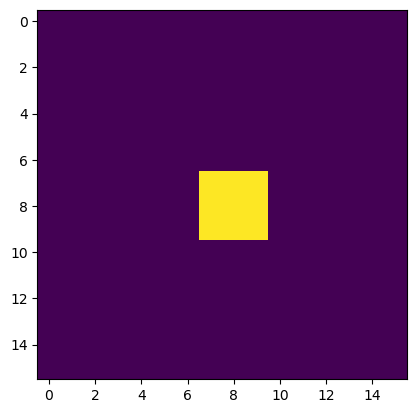

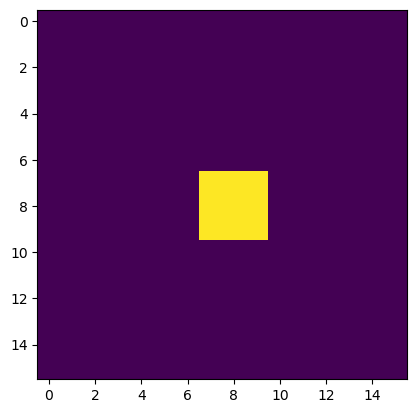

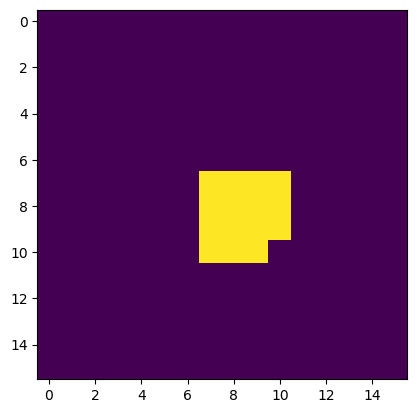

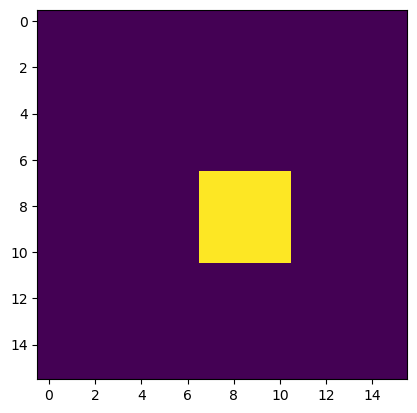

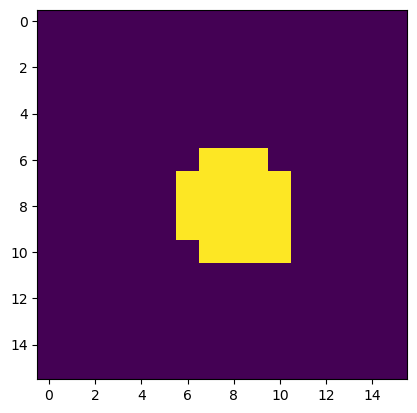

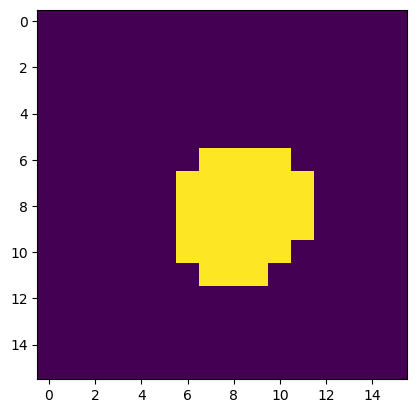

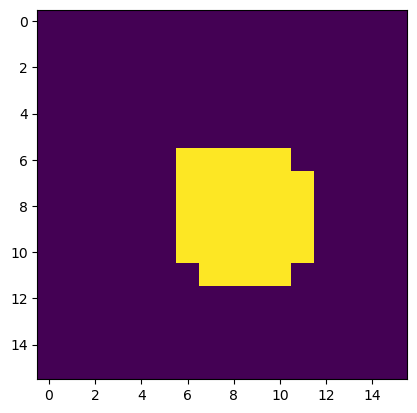

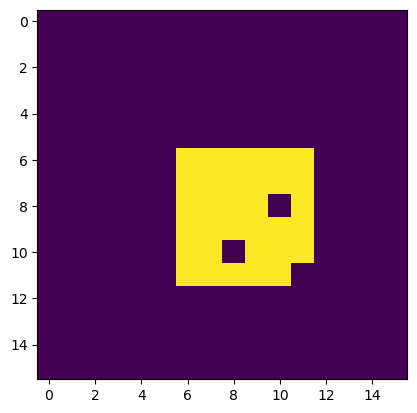

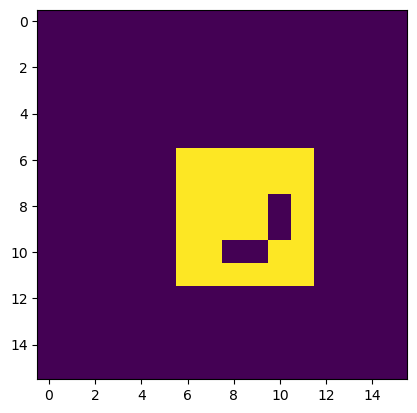

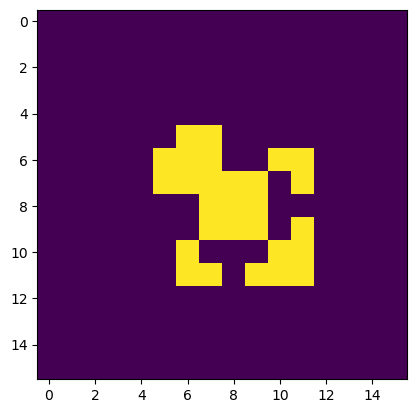

In [56]:
%pylab inline
for i in range(0,50,5):
    imshow(amr_traceamr["depth_maps"][i])
    show()



In [57]:
print("hi!")

hi!


In [58]:
amr_traceamr["depth_maps"][0].shape

(16, 16)

In [59]:
Uamr[0][0].sum(),UG[0].sum()

(Array(16382.869, dtype=float32), Array(16384., dtype=float32))

In [60]:
Uamr[0][-1].sum(),UG[-1].sum()

(Array(27681.324, dtype=float32), Array(27683.654, dtype=float32))

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


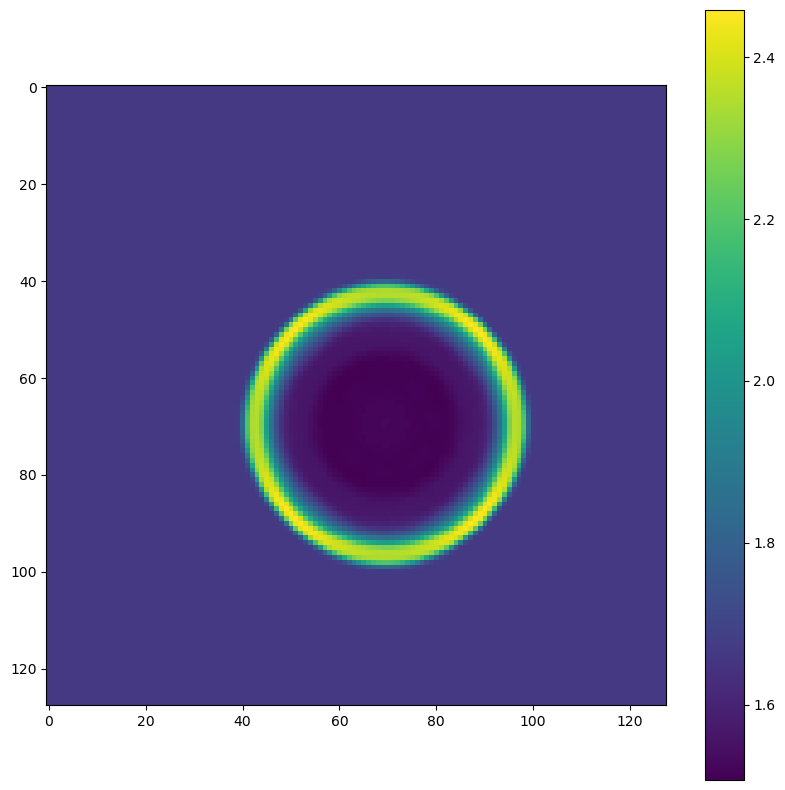

In [61]:
%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][-1])
colorbar()

In [62]:
np.arange(0,128,16)

array([  0,  16,  32,  48,  64,  80,  96, 112])

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


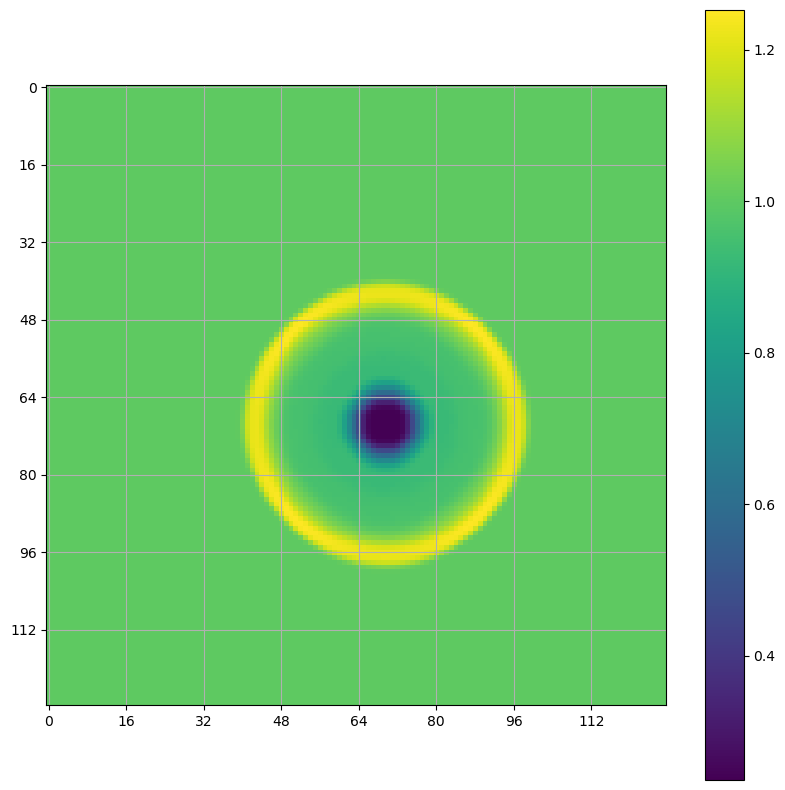

In [63]:
%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][0])#,vmin=-0.1,vmax=0.1)
grid()
xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
colorbar()

In [64]:
params = {}
from diffhydro import hydro_core_uni

hydro = hydro_core_uni.hydro(
    fluxes=[dh.ConvectiveFlux(dh.equationmanager.EquationManager(),
                              dh.LaxFriedrichs(equation_manager=dh.equationmanager.EquationManager(),
                                      signal_speed=dh.signal_speed_Rusanov),
                              dh.MUSCL3(limiter="SUPERBEE"))],
    maxjit=True,
    splitting_schemes=[[1,2,2,1],[2,1,1,2]],
    n_super_step=75 #not sure why this one is ~50% more always... timestepping in AMR probably wrong...
)
Uamr_no = hydro.evolve(UG, params)


dt [Traced<ShapedArray(float32[])>with<DynamicJaxprTrace>, 10000000000.0]


%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


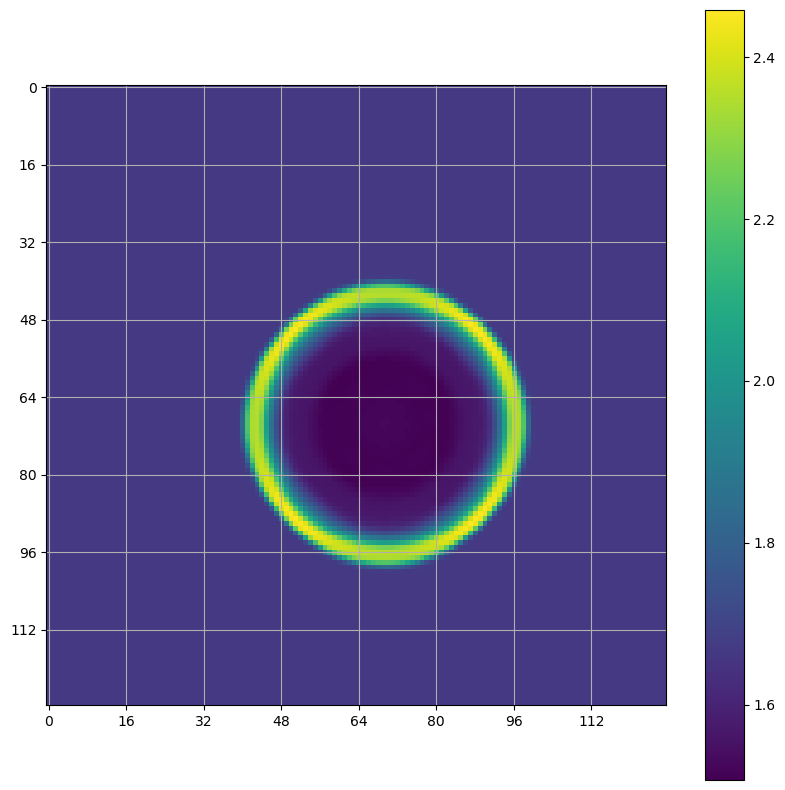

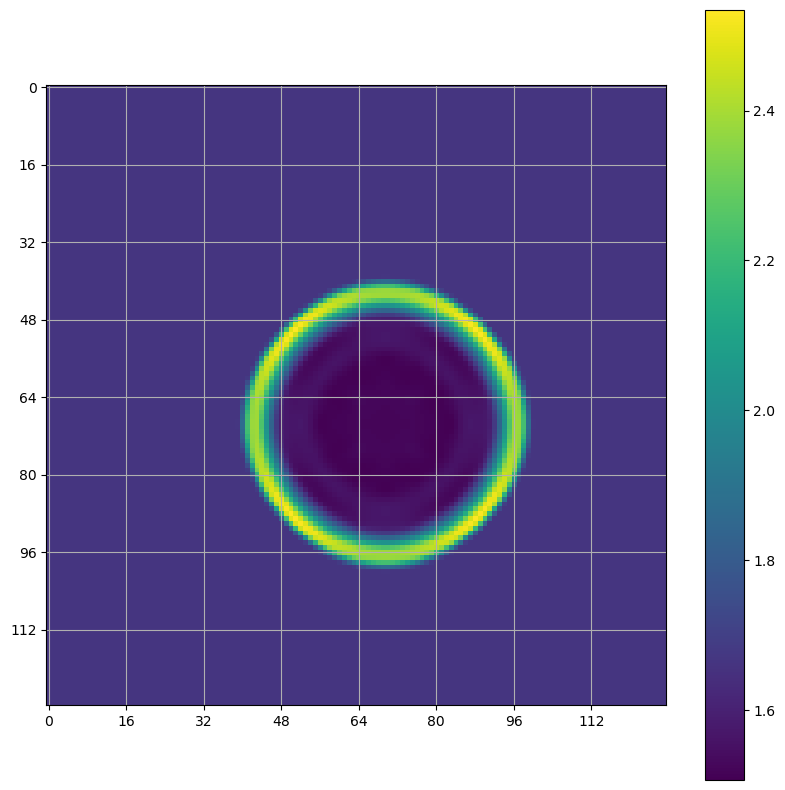

In [65]:

%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][-1])#,vmin=-0.1,vmax=0.1)
grid()
xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
colorbar()
show()
figure(figsize=(10,10))

imshow(Uamr_no[0][-1])

xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
grid()

colorbar()

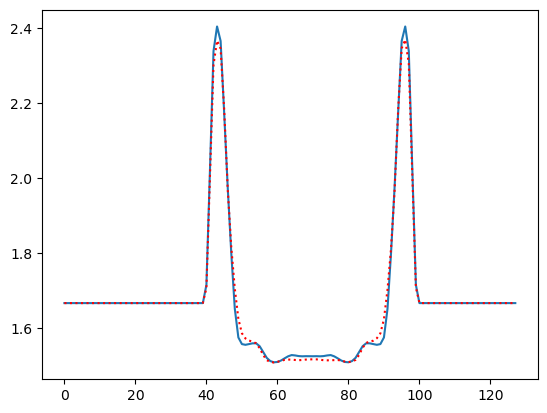

In [66]:
plot(Uamr_no[0][-1][64])
plot(Uamr[0][-1][64],"r:")

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


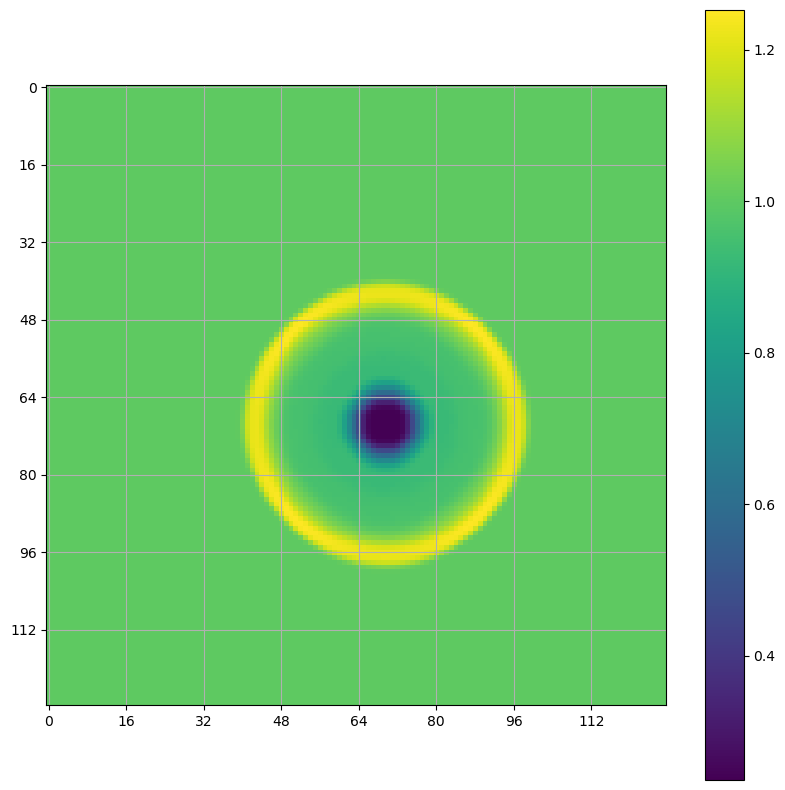

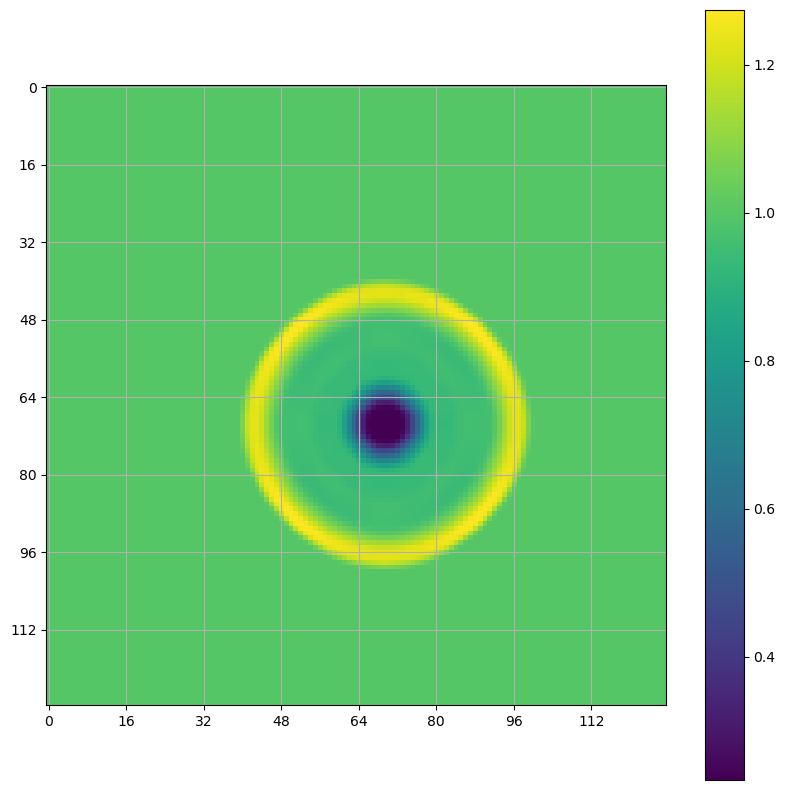

In [67]:

%pylab inline
figure(figsize=(10,10))
imshow(Uamr[0][0])#,vmin=-0.1,vmax=0.1)
grid()
xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
colorbar()
show()
figure(figsize=(10,10))

imshow(Uamr_no[0][0])

xticks(np.arange(0,128,16))
yticks(np.arange(0,128,16))
grid()

colorbar()

In [49]:
#no obvious bugs! AMR is smoother, which kinda makes sense to me (weird bumps probably discritization-type errors?)